# Interactive EpiMine Parameter Tuning & QA Testing

This notebook allows you to:
1. Load a sample scene graph from hard_10 benchmark
2. Tune EpiMine parameters (threshold_std, min_freq, top_k)
3. Generate episode hierarchy on-demand
4. View different prompt types (vanilla, hierarchical, CoT)
5. Run QA and check answer for specific cases

**Enhanced with visualizations from:**
- `hard10_visualization.ipynb` - Scene graph timeline with hand coloring
- `episode_hierarchy_viz.ipynb` - Episode hierarchy cards and flow diagrams

## 1. Imports & Setup

In [1]:
import sys
import json
import re
import numpy as np
from pathlib import Path
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# Add parent directories to path
ROOT_DIR = Path('/home/jtu9/sgg/tsg-bench')
sys.path.insert(0, str(ROOT_DIR))

from anygran.epimine_hierarchical_sgqa import (
    EpiMineActionAnalyzer,
    EpiMineEpisodeGenerator,
    EpiMineHierarchicalEvaluator,
    GPT5Mini,
    GPT5,
    GPT5Pro,
    GPT51,
    build_background_dataset,
    extract_structured_info,
    extract_terms_from_action,
    get_action_verb,
    load_prompt,
)

# Import visualization tools
from visualization import draw_scene_graph, draw_context_graphs, NODE_COLORS

print("Imports successful!")

Imports successful!


## 2. Visualization Helper Functions

In [2]:
# ============================================================================
# Color Schemes
# ============================================================================

# Hand usage colors (from hard10_visualization.ipynb)
HAND_COLORS = {
    'hand1': '#4A90D9',      # Blue
    'hand2': '#D94A4A',      # Red
    'both': '#9B59B6',       # Purple
    'none': '#CCCCCC',       # Gray
}
GT_COLOR = '#FFD700'  # Gold for ground truth
GT_BORDER = '#B8860B'  # Dark gold border

# Episode colors (from episode_hierarchy_viz.ipynb)
EPISODE_COLORS = [
    '#3498DB',  # Blue
    '#E74C3C',  # Red
    '#2ECC71',  # Green
    '#9B59B6',  # Purple
    '#F39C12',  # Orange
    '#1ABC9C',  # Teal
    '#E91E63',  # Pink
    '#00BCD4',  # Cyan
]

POSITION_COLORS = {
    'beginning': '#27AE60',
    'middle': '#3498DB',
    'end': '#E74C3C',
}

print("Color schemes loaded!")

Color schemes loaded!


In [3]:
# ============================================================================
# Scene Graph Visualization Functions (from hard10_visualization.ipynb)
# ============================================================================

def extract_action_info(graph_triplets):
    """Extract verb, object, and hand usage from a single action graph."""
    info = {
        'verb': None,
        'object': None,
        'hands': [],
        'is_both_hands': False,
        'locations': [],
    }
    
    for triplet in graph_triplets:
        if len(triplet) < 3:
            continue
        subj, rel, obj = triplet[0], triplet[1], triplet[2]
        
        if rel == 'verb':
            info['verb'] = obj
        elif rel == 'dobj':
            info['object'] = obj
        elif rel == 'with' and obj.startswith('hand'):
            info['hands'].append(obj)
        elif rel in ['from', 'to', 'on', 'onto', 'into', 'in']:
            info['locations'].append((rel, obj))
    
    info['is_both_hands'] = len(info['hands']) == 2
    return info


def get_hand_color(hands):
    """Get color based on hand usage."""
    if len(hands) == 2:
        return HAND_COLORS['both']
    elif 'hand1' in hands:
        return HAND_COLORS['hand1']
    elif 'hand2' in hands:
        return HAND_COLORS['hand2']
    return HAND_COLORS['none']


def get_hand_label(hands):
    """Get label for hand usage."""
    if len(hands) == 2:
        return 'H1+H2'
    elif 'hand1' in hands:
        return 'H1'
    elif 'hand2' in hands:
        return 'H2'
    return '-'


def create_timeline_figure(case, figsize=(18, 5)):
    """Create horizontal timeline with hand-usage coloring and GT highlighting."""
    context_graphs = case['context_graphs']
    ground_truth = case['ground_truth'].lower()
    n_frames = len(context_graphs)
    
    # Extract info for each frame
    timeline = [extract_action_info(g) for g in context_graphs]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot parameters
    bar_height = 0.6
    y_verb = 2
    y_obj = 1
    y_hand = 0
    
    # Find frames where ground truth appears
    gt_frames = []
    for i, info in enumerate(timeline):
        if info['object'] and ground_truth in info['object'].lower():
            gt_frames.append(i)
    
    # Plot each frame
    for i, info in enumerate(timeline):
        x = i
        hand_color = get_hand_color(info['hands'])
        is_gt = i in gt_frames
        
        # Background highlight for GT frames
        if is_gt:
            ax.axvspan(x - 0.45, x + 0.45, alpha=0.2, color=GT_COLOR, zorder=0)
        
        # Verb box
        verb_text = info['verb'] if info['verb'] else '?'
        verb_color = NODE_COLORS['verb']
        rect = FancyBboxPatch(
            (x - 0.4, y_verb - bar_height/2), 0.8, bar_height,
            boxstyle="round,pad=0.02,rounding_size=0.1",
            facecolor=verb_color, edgecolor='white', linewidth=2
        )
        ax.add_patch(rect)
        ax.text(x, y_verb, verb_text, ha='center', va='center', 
                fontsize=8, fontweight='bold', color='white')
        
        # Object box
        obj_text = info['object'] if info['object'] else '?'
        obj_color = GT_COLOR if is_gt else NODE_COLORS['object']
        edge_color = GT_BORDER if is_gt else 'white'
        edge_width = 3 if is_gt else 2
        rect = FancyBboxPatch(
            (x - 0.4, y_obj - bar_height/2), 0.8, bar_height,
            boxstyle="round,pad=0.02,rounding_size=0.1",
            facecolor=obj_color, edgecolor=edge_color, linewidth=edge_width
        )
        ax.add_patch(rect)
        # Truncate long object names
        if len(obj_text) > 10:
            obj_text = obj_text[:9] + '.'
        ax.text(x, y_obj, obj_text, ha='center', va='center', 
                fontsize=7, fontweight='bold', color='black' if is_gt else 'white')
        
        # Hand indicator
        hand_label = get_hand_label(info['hands'])
        rect = FancyBboxPatch(
            (x - 0.3, y_hand - bar_height/3), 0.6, bar_height/1.5,
            boxstyle="round,pad=0.02,rounding_size=0.1",
            facecolor=hand_color, edgecolor='white', linewidth=1.5
        )
        ax.add_patch(rect)
        ax.text(x, y_hand, hand_label, ha='center', va='center', 
                fontsize=8, fontweight='bold', color='white')
        
        # Frame number
        ax.text(x, -0.7, f'{i}', ha='center', va='center', fontsize=8, color='gray')
    
    # Labels
    ax.text(-0.8, y_verb, 'Action', ha='right', va='center', fontsize=10, fontweight='bold')
    ax.text(-0.8, y_obj, 'Object', ha='right', va='center', fontsize=10, fontweight='bold')
    ax.text(-0.8, y_hand, 'Hand', ha='right', va='center', fontsize=10, fontweight='bold')
    ax.text(-0.8, -0.7, 'Frame', ha='right', va='center', fontsize=10, fontweight='bold', color='gray')
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=HAND_COLORS['hand1'], label='Hand 1 (H1)', edgecolor='white'),
        mpatches.Patch(facecolor=HAND_COLORS['hand2'], label='Hand 2 (H2)', edgecolor='white'),
        mpatches.Patch(facecolor=HAND_COLORS['both'], label='Both Hands (H1+H2)', edgecolor='white'),
        mpatches.Patch(facecolor=GT_COLOR, label=f'Ground Truth: {ground_truth}', edgecolor=GT_BORDER, linewidth=2),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.95)
    
    # Styling
    ax.set_xlim(-1.2, n_frames - 0.3)
    ax.set_ylim(-1.2, 3)
    ax.axis('off')
    ax.set_title('Action Timeline with Hand Usage', fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()
    return fig


def display_case_header(case, case_idx):
    """Display case header with question, GT, predictions."""
    error_cat = case.get('error_category', 'unknown')
    predictions = case.get('predictions', {})
    
    # Color code error category
    cat_colors = {
        'both_hands': '#9B59B6',
        'concurrent_state': '#E74C3C',
        'multi_step': '#3498DB',
        'temporal_ordering': '#2ECC71',
    }
    cat_color = cat_colors.get(error_cat, '#95A5A6')
    
    html = f"""
    <div style="border: 2px solid #333; border-radius: 10px; padding: 15px; margin: 10px 0; background: #f8f9fa;">
        <h2 style="margin-top: 0;">Case {case_idx + 1}: {case['data_id'][:12]}...</h2>
        <p style="background: {cat_color}; color: white; padding: 5px 10px; border-radius: 5px; display: inline-block; font-weight: bold;">
            {error_cat.replace('_', ' ').title()}
        </p>
        <h3 style="color: #2C3E50;">Question</h3>
        <p style="font-size: 16px; font-style: italic; background: #ECF0F1; padding: 10px; border-radius: 5px;">
            {case['question']}
        </p>
        <h3 style="color: #27AE60;">Ground Truth</h3>
        <p style="font-size: 18px; font-weight: bold; color: #27AE60; background: #D5F5E3; padding: 10px; border-radius: 5px;">
            {case['ground_truth']}
        </p>
    """
    
    if predictions:
        html += """
        <h3 style="color: #E74C3C;">Model Predictions</h3>
        <table style="width: 100%; border-collapse: collapse;">
            <tr style="background: #FADBD8;">
                <th style="padding: 8px; border: 1px solid #ddd;">Model</th>
                <th style="padding: 8px; border: 1px solid #ddd;">Prediction</th>
                <th style="padding: 8px; border: 1px solid #ddd;">Correct?</th>
            </tr>
        """
        
        for model, pred_info in predictions.items():
            if isinstance(pred_info, dict):
                pred_answer = pred_info.get('answer', '')
                is_correct = pred_info.get('correct', False)
            else:
                pred_answer = str(pred_info)
                is_correct = pred_answer.lower().strip() == case['ground_truth'].lower().strip()
            
            icon = '&#10004;' if is_correct else '&#10008;'
            color = '#27AE60' if is_correct else '#E74C3C'
            html += f"""
                <tr>
                    <td style="padding: 8px; border: 1px solid #ddd;">{model}</td>
                    <td style="padding: 8px; border: 1px solid #ddd;">{pred_answer}</td>
                    <td style="padding: 8px; border: 1px solid #ddd; color: {color}; font-weight: bold;">{icon}</td>
                </tr>
            """
        html += "</table>"
    
    html += "</div>"
    display(HTML(html))


print("Scene graph visualization functions loaded!")

Scene graph visualization functions loaded!


In [4]:
# ============================================================================
# Episode Hierarchy Visualization Functions (from episode_hierarchy_viz.ipynb)
# ============================================================================

def get_episode_color(episode_id):
    """Get color for an episode by its ID."""
    return EPISODE_COLORS[episode_id % len(EPISODE_COLORS)]


def display_goal_header(data_id, hierarchy):
    """Display the overall goal header."""
    overall_goal = hierarchy.get('overall_goal', 'No goal specified')
    episodes = hierarchy.get('episodes', [])
    
    html = f"""
    <div style="border: 3px solid #2C3E50; border-radius: 15px; padding: 20px; margin: 15px 0; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white;">
        <h2 style="margin-top: 0; color: white;">Episode Hierarchy</h2>
        
        <div style="background: rgba(255,255,255,0.15); padding: 15px; border-radius: 10px; margin: 10px 0;">
            <h3 style="margin: 0 0 10px 0; color: #F1C40F;">Overall Goal</h3>
            <p style="font-size: 16px; margin: 0; font-style: italic;">{overall_goal}</p>
        </div>
        
        <div style="display: flex; gap: 20px; margin-top: 15px;">
            <div style="flex: 1; background: rgba(255,255,255,0.1); padding: 10px; border-radius: 8px;">
                <strong style="color: #F1C40F;">Episodes:</strong> {len(episodes)}
            </div>
        </div>
    </div>
    """
    display(HTML(html))


def create_episode_timeline(hierarchy, figsize=(18, 6)):
    """Create a horizontal timeline showing episode boundaries."""
    episodes = hierarchy.get('episodes', [])
    if not episodes:
        return None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Find total action range
    all_indices = []
    for ep in episodes:
        all_indices.extend(ep.get('time', {}).get('action_indices', []))
    
    if not all_indices:
        return None
    
    min_idx = min(all_indices)
    max_idx = max(all_indices)
    
    # Draw episode bars
    bar_height = 0.6
    
    for i, ep in enumerate(episodes):
        ep_id = ep.get('episode_id', i)
        time_info = ep.get('time', {})
        start = time_info.get('start_index', 0)
        end = time_info.get('end_index', start)
        duration = end - start + 1
        
        color = get_episode_color(ep_id)
        y = len(episodes) - i - 1  # Stack from bottom
        
        # Episode bar
        rect = FancyBboxPatch(
            (start, y - bar_height/2), duration, bar_height,
            boxstyle="round,pad=0.02,rounding_size=0.2",
            facecolor=color, edgecolor='white', linewidth=2, alpha=0.85
        )
        ax.add_patch(rect)
        
        # Episode label
        name = ep.get('name', f'Episode {ep_id}')
        if len(name) > 20:
            name = name[:18] + '..'
        ax.text(start + duration/2, y, name, ha='center', va='center',
                fontsize=9, fontweight='bold', color='white')
        
        # Duration label
        ax.text(start + duration/2, y - 0.35, f'[{start}-{end}] ({duration} actions)',
                ha='center', va='top', fontsize=7, color='gray')
        
        # Salience score
        salience = ep.get('salience_score', 0)
        ax.text(end + 0.5, y, f'{salience:.2f}', ha='left', va='center',
                fontsize=8, color=color, fontweight='bold')
    
    # Add legend
    legend_elements = []
    for i, ep in enumerate(episodes):
        ep_id = ep.get('episode_id', i)
        color = get_episode_color(ep_id)
        name = ep.get('name', f'Episode {ep_id}')
        legend_elements.append(
            mpatches.Patch(facecolor=color, label=f'E{ep_id}: {name[:25]}', edgecolor='white')
        )
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8, framealpha=0.95)
    
    # Frame markers
    ax.set_xlim(min_idx - 1, max_idx + 3)
    ax.set_ylim(-1, len(episodes))
    ax.set_xticks(range(min_idx, max_idx + 1))
    ax.set_xticklabels([str(i) for i in range(min_idx, max_idx + 1)], fontsize=8)
    ax.set_xlabel('Action Frame Index', fontsize=10, fontweight='bold')
    ax.set_yticks([])
    ax.set_title('Episode Timeline (with salience scores)', fontsize=12, fontweight='bold', pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.tight_layout()
    return fig


def display_episode_cards(hierarchy):
    """Display detailed cards for each episode."""
    episodes = hierarchy.get('episodes', [])
    
    html = '<div style="display: flex; flex-wrap: wrap; gap: 15px; margin: 15px 0;">'
    
    for ep in episodes:
        ep_id = ep.get('episode_id', 0)
        color = get_episode_color(ep_id)
        name = ep.get('name', f'Episode {ep_id}')
        desc = ep.get('description', '')
        
        # Core structure
        structure = ep.get('core_structure', {})
        actions = structure.get('primary_actions', [])
        objects = structure.get('primary_objects', [])
        instruments = structure.get('instruments', [])
        sources = structure.get('source_locations', []) or []
        targets = structure.get('target_locations', []) or []
        
        # Time info
        time_info = ep.get('time', {})
        start = time_info.get('start_index', 0)
        end = time_info.get('end_index', 0)
        duration = time_info.get('duration', 0)
        
        # Temporal context
        temporal = ep.get('temporal_context', {})
        position = temporal.get('position', 'unknown')
        pos_color = POSITION_COLORS.get(position, '#95A5A6')
        
        # Discriminative terms
        terms = ep.get('discriminative_terms', [])
        salience = ep.get('salience_score', 0)
        
        html += f"""
        <div style="flex: 1; min-width: 350px; max-width: 500px; border: 2px solid {color}; border-radius: 12px; padding: 15px; background: white; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
            <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 10px;">
                <h3 style="margin: 0; color: {color};">Episode {ep_id}: {name}</h3>
                <span style="background: {pos_color}; color: white; padding: 3px 8px; border-radius: 12px; font-size: 11px;">{position}</span>
            </div>
            
            <p style="color: #555; font-style: italic; margin: 5px 0 15px 0; font-size: 13px;">{desc}</p>
            
            <div style="background: #f8f9fa; padding: 10px; border-radius: 8px; margin-bottom: 10px;">
                <div style="display: flex; gap: 10px; flex-wrap: wrap; font-size: 12px;">
                    <span><strong>Frames:</strong> {start}-{end}</span>
                    <span><strong>Duration:</strong> {duration}</span>
                    <span><strong>Salience:</strong> {salience:.3f}</span>
                </div>
            </div>
            
            <div style="font-size: 12px;">
                <p style="margin: 5px 0;"><strong style="color: {NODE_COLORS['verb']};">Actions:</strong> {', '.join(actions[:5])}{' ...' if len(actions) > 5 else ''}</p>
                <p style="margin: 5px 0;"><strong style="color: {NODE_COLORS['object']};">Objects:</strong> {', '.join(objects[:5])}{' ...' if len(objects) > 5 else ''}</p>
                <p style="margin: 5px 0;"><strong style="color: #FFE66D;">Instruments:</strong> {', '.join(instruments) if instruments else 'N/A'}</p>
                <p style="margin: 5px 0;"><strong>Locations:</strong> {' -> '.join(sources[:2]) if sources else '?'} &#8594; {' -> '.join(targets[:2]) if targets else '?'}</p>
            </div>
            
            <div style="margin-top: 10px; padding-top: 10px; border-top: 1px solid #eee;">
                <strong style="font-size: 11px; color: #888;">Key Terms:</strong>
                <div style="display: flex; flex-wrap: wrap; gap: 5px; margin-top: 5px;">
        """
        
        for term in terms[:6]:
            html += f'<span style="background: {color}22; color: {color}; padding: 2px 8px; border-radius: 10px; font-size: 11px; border: 1px solid {color};">{term}</span>'
        
        html += """
                </div>
            </div>
        </div>
        """
    
    html += '</div>'
    display(HTML(html))


def create_temporal_flow(hierarchy, figsize=(14, 5)):
    """Create a diagram showing episode temporal dependencies."""
    episodes = hierarchy.get('episodes', [])
    if len(episodes) <= 1:
        return None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Position episodes horizontally by start time
    positions = {}
    for i, ep in enumerate(episodes):
        ep_id = ep.get('episode_id', i)
        start = ep.get('time', {}).get('start_index', i * 5)
        positions[ep_id] = (start, 0)
    
    # Draw episode nodes
    for ep in episodes:
        ep_id = ep.get('episode_id', 0)
        name = ep.get('name', f'E{ep_id}')
        if len(name) > 15:
            name = name[:13] + '..'
        
        x, y = positions[ep_id]
        color = get_episode_color(ep_id)
        
        circle = plt.Circle((x, y), 1.5, color=color, ec='white', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, f'E{ep_id}', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
        ax.text(x, y - 2.2, name, ha='center', va='top', fontsize=8, color=color)
        
        # Draw arrows to following episodes
        precedes = ep.get('temporal_context', {}).get('precedes_episodes', [])
        if precedes:
            for next_id in precedes:
                if next_id in positions:
                    x2, y2 = positions[next_id]
                    ax.annotate('', xy=(x2 - 1.6, y2), xytext=(x + 1.6, y),
                               arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
    
    # Adjust view
    all_x = [p[0] for p in positions.values()]
    ax.set_xlim(min(all_x) - 4, max(all_x) + 4)
    ax.set_ylim(-4, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Temporal Flow: Episode Dependencies', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig


print("Episode hierarchy visualization functions loaded!")

Episode hierarchy visualization functions loaded!


## 3. Load Data

In [5]:
# Paths
HARD_10_PATH = ROOT_DIR / 'anygran' / 'benchmarks' / 'hard_10' / 'sgqa_hard_10.json'
SGQA_PATH = ROOT_DIR / 'resource' / 'dataset' / 'understanding' / 'sgqa.jsonl'

# Load hard_10 benchmark
with open(HARD_10_PATH, "r", encoding="utf-8") as f:
    hard_10_data = json.load(f)
cases = hard_10_data["cases"]
print(f"Loaded {len(cases)} hard cases")

# Build background dataset
print("Building background dataset from all SGQA actions...")
background = build_background_dataset(str(SGQA_PATH))
print(f"Background dataset: {len(background)} action graphs")

Loaded 10 hard cases
Building background dataset from all SGQA actions...
Background dataset: 2546 action graphs


## 4. Sample Selector

Select which case to analyze (0-9)

In [6]:
# ====== CONFIGURE: Select case index (0-9) ======
CASE_INDEX = 0
# ================================================

case = cases[CASE_INDEX]

# Display rich case header
display_case_header(case, CASE_INDEX)

Model,Prediction,Correct?
epimine_v0,paper,✘
baseline_mini,paper,✘
baseline_gpt5,paper,✘


In [7]:
# Display all available cases for reference
print("\nAll Hard-10 Cases:")
print("-" * 100)
for i, c in enumerate(cases):
    gt = c['ground_truth']
    q = c['question'][:55] + "..." if len(c['question']) > 55 else c['question']
    marker = " <-- SELECTED" if i == CASE_INDEX else ""
    print(f"[{i}] {c['error_category']:<20} GT: {gt:<15} Q: {q}{marker}")


All Hard-10 Cases:
----------------------------------------------------------------------------------------------------
[0] both_hands           GT: metal-board     Q: Which object required both hands for its first manipula... <-- SELECTED
[1] concurrent_state     GT: bottle          Q: Which object was handled by both hands during the drink...
[2] multi_step           GT: bottle          Q: What was the last tool used before the final water spra...
[3] multi_step           GT: scissors        Q: Which object was manipulated immediately after the firs...
[4] multi_step           GT: knife           Q: Which tool was used after all dough kneading and adjust...
[5] multi_step           GT: paintbrush      Q: What tool was used immediately before the bolt tighteni...
[6] multi_step           GT: hose            Q: What tool was used immediately after the first water-fi...
[7] multi_step           GT: plant           Q: What object was manipulated between the two vine-cuttin...
[8] tempor

## 5. Scene Graph Timeline Visualization

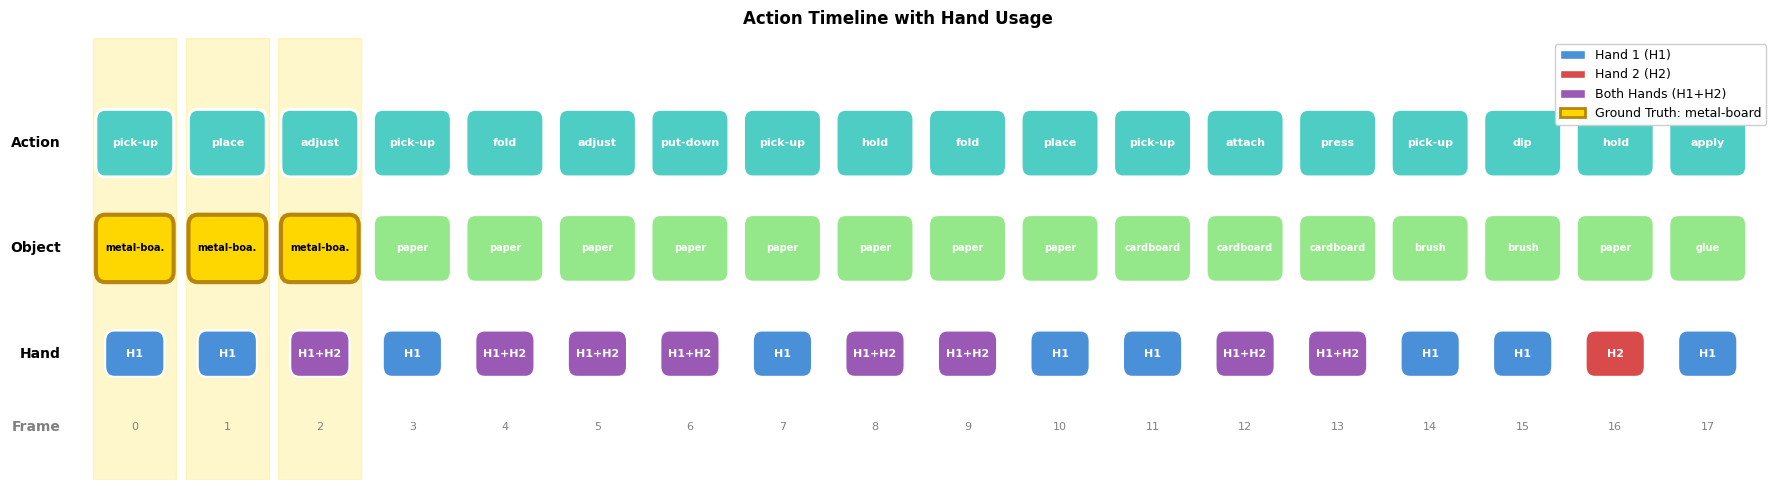

In [8]:
# Visualize scene graph timeline with hand usage coloring
fig = create_timeline_figure(case)
plt.show()
plt.close()

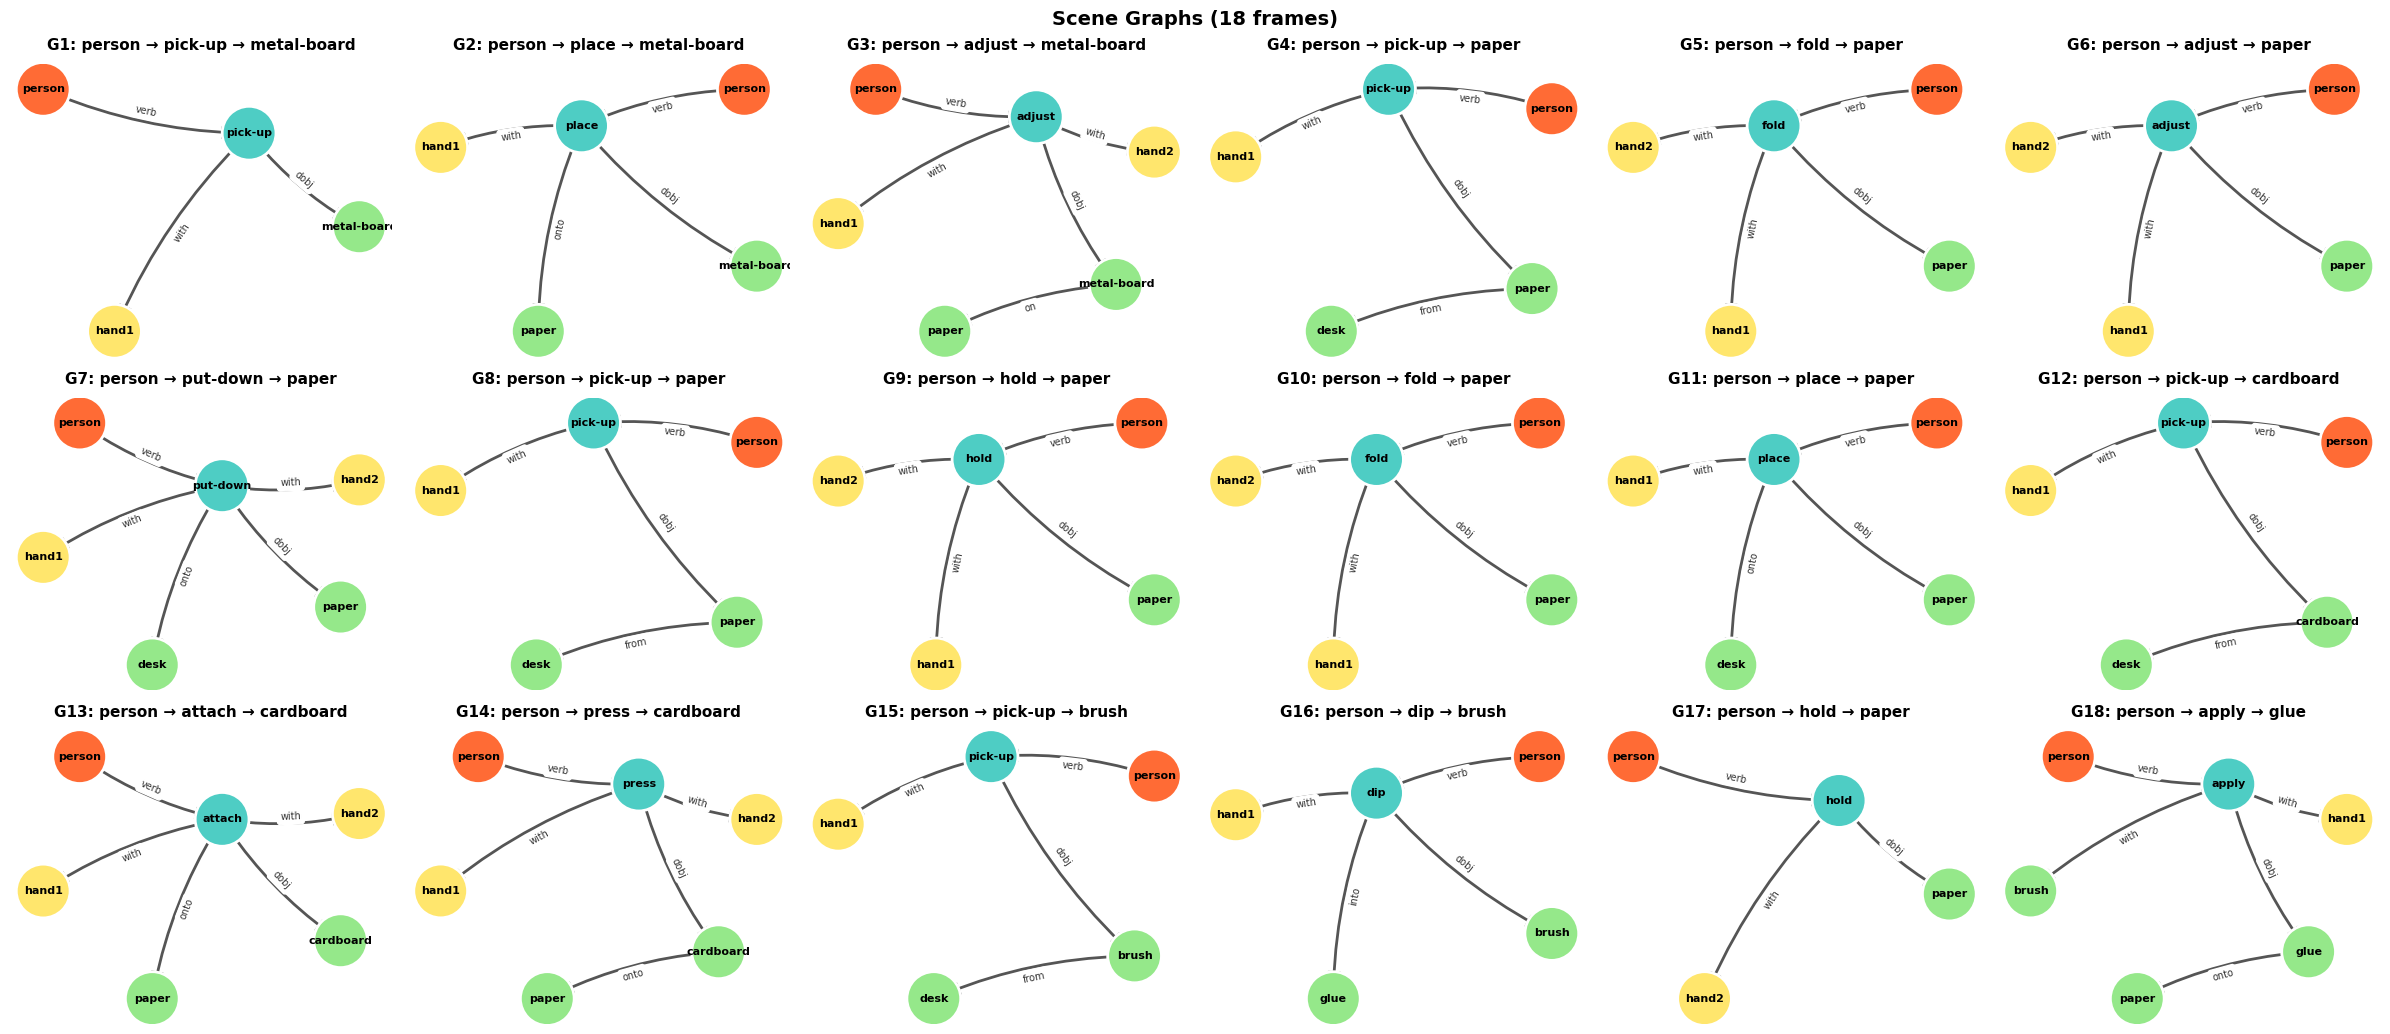

In [9]:
# Visualize scene graphs as network graphs
n_graphs = len(case['context_graphs'])
cols = min(6, n_graphs)
fig = draw_context_graphs(case['context_graphs'], cols=cols)
fig.suptitle(f'Scene Graphs ({n_graphs} frames)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

## 6. Parameter Configuration

Configure EpiMine hyperparameters

In [57]:
# ====== CONFIGURE: EpiMine Parameters ======
THRESHOLD_STD = 0.5    # Standard deviations below mean for boundary detection (default: 1.0)
MIN_FREQ = 0           # Minimum term frequency for salience calculation (default: 2)
TOP_K = None             # Limit on number of key terms (default: None = all)
USE_LLM = True         # Use LLM for episode name/description generation

# Model selection
MODEL_NAME = "gpt5-mini"  # Options: "gpt5-mini", "gpt5", "gpt5-pro", "gpt5.1"
GEN_MODEL_NAME = "gpt5.1" # Model for episode generation (if USE_LLM=True)
# ===========================================

print("Current Configuration:")
print(f"  threshold_std: {THRESHOLD_STD}")
print(f"  min_freq: {MIN_FREQ}")
print(f"  top_k: {TOP_K}")
print(f"  use_llm: {USE_LLM}")
print(f"  qa_model: {MODEL_NAME}")
print(f"  gen_model: {GEN_MODEL_NAME}")

Current Configuration:
  threshold_std: 0.5
  min_freq: 0
  top_k: None
  use_llm: True
  qa_model: gpt5-mini
  gen_model: gpt5.1


In [58]:
# Initialize analyzer with configured min_freq
analyzer = EpiMineActionAnalyzer(background_dataset=background, min_freq=MIN_FREQ)

# Initialize models
MODEL_CLASSES = {
    "gpt5-mini": GPT5Mini,
    "gpt5": GPT5,
    "gpt5-pro": GPT5Pro,
    "gpt5.1": GPT51,
}

qa_model = MODEL_CLASSES[MODEL_NAME]()
gen_model = MODEL_CLASSES[GEN_MODEL_NAME]() if USE_LLM else None

print(f"\nInitialized analyzer and models")
print(f"  QA Model: {qa_model.__class__.__name__}")
if gen_model:
    print(f"  Gen Model: {gen_model.__class__.__name__}")


Initialized analyzer and models
  QA Model: GPT5Mini
  Gen Model: GPT51


## 7. Generate Episode Hierarchy

Run EpiMine analysis and generate structured episodes

In [60]:
# Run EpiMine analysis
action_sequence = case['context_graphs']

print("Running EpiMine Analysis...")
print("=" * 60)

# Step 1: Get key terms and salience scores
key_terms = analyzer.get_key_terms(action_sequence, top_k=TOP_K)
print(f"\nKey Terms (top {TOP_K or 'all'}):")
for term, salience in key_terms[:15]:
    print(f"  {term:<20} salience: {salience:.3f}")

# Step 2: Compute co-occurrence matrix
term_list = [t for t, _ in key_terms]
if term_list:
    cooccur_matrix = analyzer.compute_cooccurrence_matrix(action_sequence, term_list)
    print(f"\nCo-occurrence matrix shape: {cooccur_matrix.shape}")
    
    # Show consecutive scores
    consecutive_scores = [cooccur_matrix[i, i+1] for i in range(len(action_sequence)-1)]
    mean_score = np.mean(consecutive_scores)
    std_score = np.std(consecutive_scores)
    threshold = mean_score - THRESHOLD_STD * std_score
    
    print(f"\nConsecutive co-occurrence scores:")
    print(f"  Mean: {mean_score:.3f}")
    print(f"  Std: {std_score:.3f}")
    print(f"  Threshold (mean - {THRESHOLD_STD}*std): {threshold:.3f}")

# Step 3: Detect episode boundaries
episode_boundaries = analyzer.detect_episode_boundaries(action_sequence, threshold_std=THRESHOLD_STD)
print(f"\nDetected Episode Boundaries:")
for i, boundary in enumerate(episode_boundaries):
    verbs = [get_action_verb(action_sequence[idx]) for idx in boundary]
    print(f"  Episode {i}: Actions {boundary} - verbs: {verbs}")

Running EpiMine Analysis...

Key Terms (top all):
  paper                salience: 34.858
  desk                 salience: 25.475
  onto                 salience: 15.443
  metal-board          salience: 14.883
  cardboard            salience: 10.388
  brush                salience: 9.007
  fold                 salience: 8.357
  glue                 salience: 7.601
  from                 salience: 6.181
  adjust               salience: 5.651
  attach               salience: 5.444
  pick-up              salience: 5.213
  hand2                salience: 4.955
  press                salience: 4.751
  apply                salience: 4.623

Co-occurrence matrix shape: (18, 18)

Consecutive co-occurrence scores:
  Mean: 0.555
  Std: 0.135
  Threshold (mean - 0.5*std): 0.488

Detected Episode Boundaries:
  Episode 0: Actions [0, 1, 2] - verbs: ['pick-up', 'place', 'adjust']
  Episode 1: Actions [3, 4, 5, 6, 7, 8, 9, 10, 11] - verbs: ['pick-up', 'fold', 'adjust', 'put-down', 'pick-up', 'hold', 'f

In [61]:
# Generate structured episode hierarchy
print("\nGenerating Episode Hierarchy...")
print("=" * 60)

generator = EpiMineEpisodeGenerator(model=gen_model) if USE_LLM else EpiMineEpisodeGenerator(model=GPT5Mini())

hierarchy = generator.generate_episode_hierarchy(
    action_sequence=action_sequence,
    episode_boundaries=episode_boundaries,
    key_terms=key_terms,
    use_llm=USE_LLM,
)

print(f"\nGenerated {len(hierarchy['episodes'])} episodes")


Generating Episode Hierarchy...

Generated 6 episodes


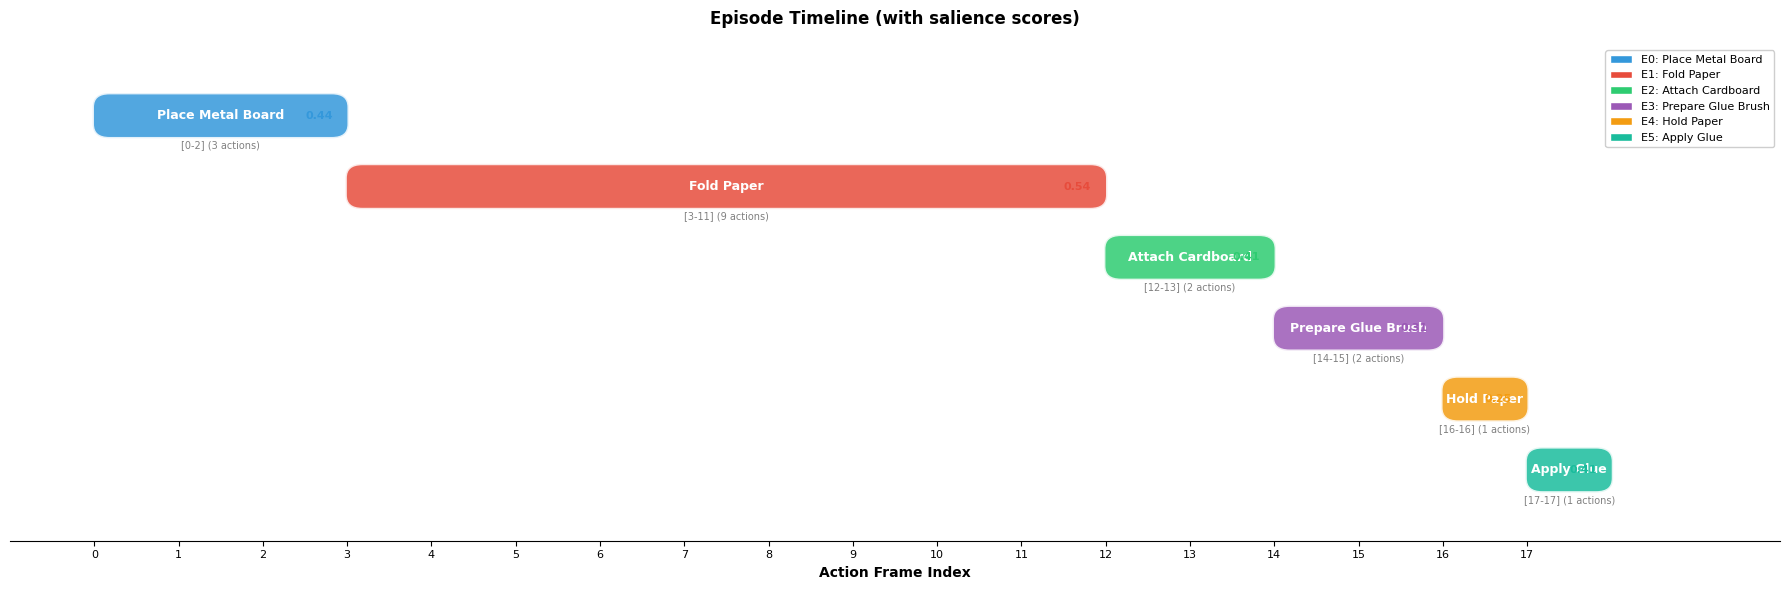

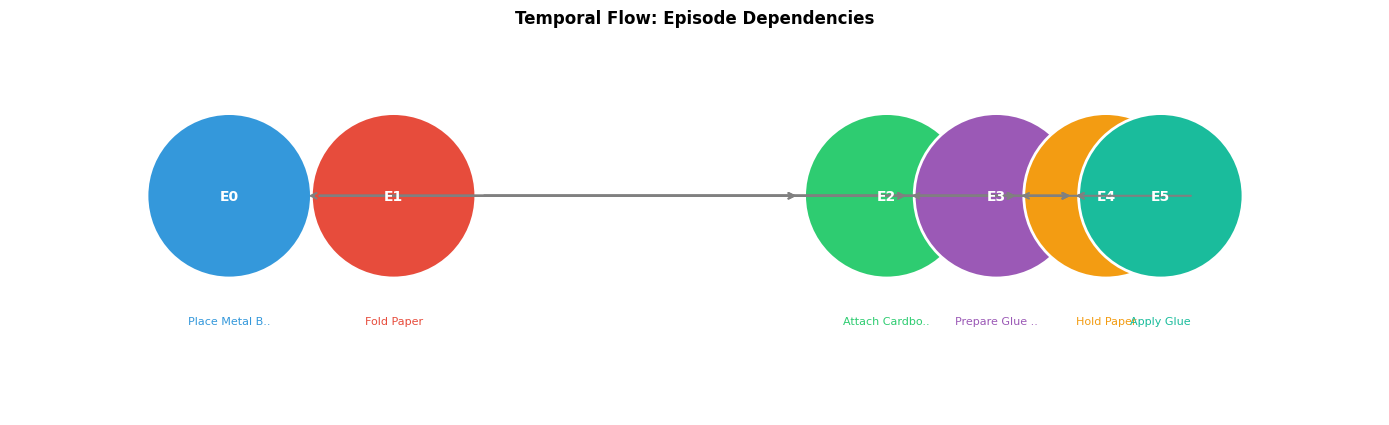

In [62]:
# Visualize the episode hierarchy

# Display goal header
display_goal_header(case['data_id'], hierarchy)

# Episode timeline
fig = create_episode_timeline(hierarchy)
if fig:
    plt.show()
    plt.close()

# Episode cards
display_episode_cards(hierarchy)

# Temporal flow (if multiple episodes)
if len(hierarchy.get('episodes', [])) > 1:
    fig = create_temporal_flow(hierarchy)
    if fig:
        plt.show()
        plt.close()

## 8. Prompt Comparison

View different prompt formats: Vanilla, Hierarchical (EpiMine), and Chain-of-Thought

In [63]:
def get_vanilla_prompt(context_graphs, question):
    """Return vanilla SGQA prompt (baseline)."""
    return f"""You are a highly advanced language model specialized in answering questions based on a given scene graph and question. Your task is to analyze the scene graph and provide the correct answer in a single word. Your output must strictly follow the format [answer], and nothing else should be printed. Ensure that your answer is concise, accurate, and matches the format exactly.

Scene Graph: {context_graphs}
Question: {question}
"""


def get_hierarchical_prompt(hierarchy, context_graphs, question):
    """Return EpiMine hierarchical prompt with episodes."""
    episodes = hierarchy.get('episodes', [])
    overall_goal = hierarchy.get('overall_goal', 'Activity sequence')
    
    # Build unified timeline
    lines = [f"## Overall Goal\n{overall_goal}\n\n## Activity Timeline\n"]
    
    for episode in episodes:
        ep_id = episode["episode_id"]
        name = episode["name"]
        description = episode["description"]
        core = episode["core_structure"]
        time_info = episode["time"]
        disc_terms = episode.get("discriminative_terms", [])
        
        lines.append(f"### Episode {ep_id}: {name}")
        lines.append(f"{description}\n")
        lines.append(f"**Structure:**")
        lines.append(f"- Agent: {core['agent']}")
        lines.append(f"- Actions: {', '.join(core['primary_actions'])}")
        if core['primary_objects']:
            lines.append(f"- Objects: {', '.join(core['primary_objects'])}")
        if core['instruments']:
            lines.append(f"- Instruments: {', '.join(core['instruments'])}")
        if core.get('source_locations'):
            lines.append(f"- From: {', '.join(core['source_locations'])}")
        if core.get('target_locations'):
            lines.append(f"- To: {', '.join(core['target_locations'])}")
        lines.append(f"- Time: Actions {time_info['action_indices']} (duration: {time_info['duration']})")
        if disc_terms:
            lines.append(f"- Key terms: {', '.join(disc_terms)}")
        lines.append("")
        
        lines.append("**Actions in this episode:**")
        for action_idx in time_info["action_indices"]:
            if action_idx < len(context_graphs):
                action_graph = context_graphs[action_idx]
                verb = get_action_verb(action_graph)
                triplets_str = " ".join(str(t) for t in action_graph)
                lines.append(f"- Action {action_idx} ({verb}): {triplets_str}")
        lines.append("")
    
    unified_timeline = "\n".join(lines)
    
    return f"""You are a highly advanced language model specialized in answering questions based on a given scene graph and question. Your task is to analyze the scene graph and provide the correct answer in a single word. Your output must strictly follow the format [answer], and nothing else should be printed. Ensure that your answer is concise, accurate, and matches the format exactly.

Scene Graph: {unified_timeline}
Question: {question}
"""


def get_cot_prompt(context_graphs, question):
    """Return Chain-of-Thought reasoning prompt."""
    return f"""You are a highly advanced language model specialized in answering questions based on a given scene graph and question. Think step by step before providing your answer.

Scene Graph: {context_graphs}
Question: {question}

Let's analyze step by step:
1. First, identify all actions in chronological order
2. Note which hands (hand1/hand2) are used for each action
3. Track object states and locations through time
4. Pay attention to temporal relationships (before, after, during)
5. Answer the question based on careful temporal reasoning

After your analysis, provide the final answer in the format [answer].
"""


print("Prompt generation functions defined.")

Prompt generation functions defined.


In [64]:
# Generate all three prompts for the current case
vanilla_prompt = get_vanilla_prompt(case['context_graphs'], case['question'])
hierarchical_prompt = get_hierarchical_prompt(hierarchy, case['context_graphs'], case['question'])
cot_prompt = get_cot_prompt(case['context_graphs'], case['question'])

print("Generated prompts for comparison.")
print(f"\nPrompt lengths:")
print(f"  Vanilla: {len(vanilla_prompt)} chars")
print(f"  Hierarchical: {len(hierarchical_prompt)} chars")
print(f"  CoT: {len(cot_prompt)} chars")

Generated prompts for comparison.

Prompt lengths:
  Vanilla: 2706 chars
  Hierarchical: 5326 chars
  CoT: 2887 chars


In [65]:
# Display Vanilla Prompt
print("\n" + "="*80)
print("VANILLA PROMPT")
print("="*80)
print(vanilla_prompt)


VANILLA PROMPT
You are a highly advanced language model specialized in answering questions based on a given scene graph and question. Your task is to analyze the scene graph and provide the correct answer in a single word. Your output must strictly follow the format [answer], and nothing else should be printed. Ensure that your answer is concise, accurate, and matches the format exactly.

Scene Graph: [[['pick-up', 'dobj', 'metal-board'], ['pick-up', 'with', 'hand1'], ['person', 'verb', 'pick-up']], [['place', 'dobj', 'metal-board'], ['place', 'onto', 'paper'], ['place', 'with', 'hand1'], ['person', 'verb', 'place']], [['adjust', 'dobj', 'metal-board'], ['metal-board', 'on', 'paper'], ['adjust', 'with', 'hand1'], ['adjust', 'with', 'hand2'], ['person', 'verb', 'adjust']], [['pick-up', 'dobj', 'paper'], ['paper', 'from', 'desk'], ['pick-up', 'with', 'hand1'], ['person', 'verb', 'pick-up']], [['fold', 'dobj', 'paper'], ['fold', 'with', 'hand1'], ['fold', 'with', 'hand2'], ['person', 've

In [66]:
# Display Hierarchical (EpiMine) Prompt
print("\n" + "="*80)
print("HIERARCHICAL (EPIMINE) PROMPT")
print("="*80)
print(hierarchical_prompt)


HIERARCHICAL (EPIMINE) PROMPT
You are a highly advanced language model specialized in answering questions based on a given scene graph and question. Your task is to analyze the scene graph and provide the correct answer in a single word. Your output must strictly follow the format [answer], and nothing else should be printed. Ensure that your answer is concise, accurate, and matches the format exactly.

Scene Graph: ## Overall Goal
The person prepares paper and cardboard, then applies glue with a brush to assemble a glued paper-cardboard construction.

## Activity Timeline

### Episode 0: Place Metal Board
The person picks up a metal board and places it onto paper, then adjusts its position.

**Structure:**
- Agent: person
- Actions: pick-up, place, adjust
- Objects: metal-board
- Instruments: hand1, hand2
- To: paper
- Time: Actions [0, 1, 2] (duration: 3)
- Key terms: paper, onto, metal-board, adjust, pick-up

**Actions in this episode:**
- Action 0 (pick-up): ['pick-up', 'dobj', 'm

In [67]:
# Display Chain-of-Thought Prompt
print("\n" + "="*80)
print("CHAIN-OF-THOUGHT PROMPT")
print("="*80)
print(cot_prompt)


CHAIN-OF-THOUGHT PROMPT
You are a highly advanced language model specialized in answering questions based on a given scene graph and question. Think step by step before providing your answer.

Scene Graph: [[['pick-up', 'dobj', 'metal-board'], ['pick-up', 'with', 'hand1'], ['person', 'verb', 'pick-up']], [['place', 'dobj', 'metal-board'], ['place', 'onto', 'paper'], ['place', 'with', 'hand1'], ['person', 'verb', 'place']], [['adjust', 'dobj', 'metal-board'], ['metal-board', 'on', 'paper'], ['adjust', 'with', 'hand1'], ['adjust', 'with', 'hand2'], ['person', 'verb', 'adjust']], [['pick-up', 'dobj', 'paper'], ['paper', 'from', 'desk'], ['pick-up', 'with', 'hand1'], ['person', 'verb', 'pick-up']], [['fold', 'dobj', 'paper'], ['fold', 'with', 'hand1'], ['fold', 'with', 'hand2'], ['person', 'verb', 'fold']], [['adjust', 'dobj', 'paper'], ['adjust', 'with', 'hand1'], ['adjust', 'with', 'hand2'], ['person', 'verb', 'adjust']], [['put-down', 'dobj', 'paper'], ['put-down', 'onto', 'desk'], ['p

## 9. Run QA & Check Answer

Select a prompt type and run the model to get predictions

In [68]:
def run_single_qa(model, prompt):
    """Run single QA and extract answer."""
    response = model.invoke(prompt)
    answer = re.findall(r"\[(.*?)\]", response)
    prediction = answer[0] if answer else response.strip()
    return prediction, response


def check_answer(prediction, ground_truth):
    """Check if prediction matches ground truth."""
    return prediction.lower().strip() == ground_truth.lower().strip()


print("QA helper functions defined.")

QA helper functions defined.


In [69]:
# ====== CONFIGURE: Select prompt type ======
PROMPT_TYPE = "hierarchical"  # Options: "vanilla", "hierarchical", "cot"
# ===========================================

# Select prompt
prompts = {
    "vanilla": vanilla_prompt,
    "hierarchical": hierarchical_prompt,
    "cot": cot_prompt,
}
selected_prompt = prompts[PROMPT_TYPE]

print(f"Running QA with {PROMPT_TYPE.upper()} prompt...")
print(f"Model: {qa_model.__class__.__name__}")
print(f"Question: {case['question']}")
print(f"Ground Truth: {case['ground_truth']}")
print("\n" + "="*60)

# Run inference
prediction, full_response = run_single_qa(qa_model, selected_prompt)
is_correct = check_answer(prediction, case['ground_truth'])

# Display results
print(f"\n{'='*60}")
print(f"RESULTS")
print(f"{'='*60}")
print(f"Prediction: {prediction}")
print(f"Ground Truth: {case['ground_truth']}")
print(f"Correct: {'YES' if is_correct else 'NO'}")
print(f"\n--- Full Model Response ---")
print(full_response)

Running QA with HIERARCHICAL prompt...
Model: GPT5Mini
Question: Which object required both hands for its first manipulation after being picked up?
Ground Truth: metal-board


RESULTS
Prediction: paper
Ground Truth: metal-board
Correct: NO

--- Full Model Response ---
[paper]


In [70]:
# Run all three prompt types and compare
print("\nComparing all prompt types...")
print("=" * 80)

results = {}
for prompt_type, prompt in prompts.items():
    print(f"\nRunning {prompt_type}...")
    pred, resp = run_single_qa(qa_model, prompt)
    correct = check_answer(pred, case['ground_truth'])
    results[prompt_type] = {
        'prediction': pred,
        'correct': correct,
        'response': resp
    }

print("\n" + "=" * 80)
print("COMPARISON RESULTS")
print("=" * 80)
print(f"\nQuestion: {case['question']}")
print(f"Ground Truth: {case['ground_truth']}")
print(f"\n{'Prompt Type':<15} {'Prediction':<20} {'Correct':<10}")
print("-" * 50)
for prompt_type, result in results.items():
    status = 'YES' if result['correct'] else 'NO'
    print(f"{prompt_type:<15} {result['prediction']:<20} {status:<10}")


Comparing all prompt types...

Running vanilla...

Running hierarchical...

Running cot...

COMPARISON RESULTS

Question: Which object required both hands for its first manipulation after being picked up?
Ground Truth: metal-board

Prompt Type     Prediction           Correct   
--------------------------------------------------
vanilla         cardboard            NO        
hierarchical    paper                NO        
cot             paper, cardboard     NO        


## 10. Analysis Dashboard

Visualize episode boundaries, key terms, and co-occurrence patterns

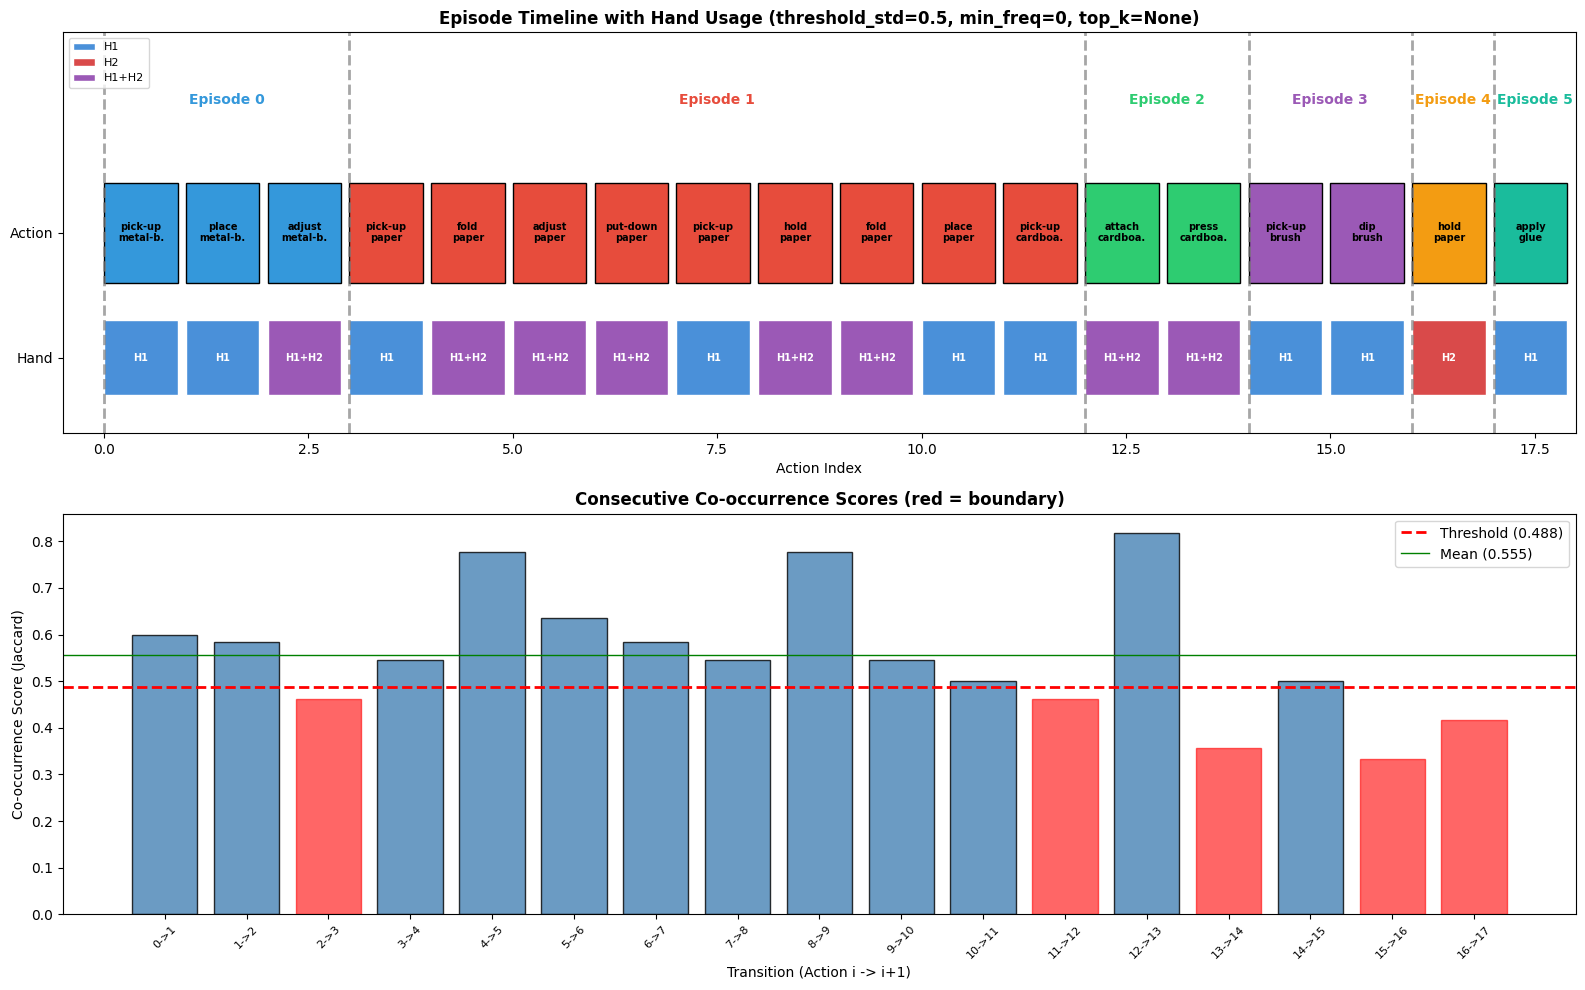

In [71]:
# Visualize episode boundaries on timeline with co-occurrence scores
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Colors for episodes
episode_colors = [get_episode_color(i) for i in range(len(episode_boundaries))]

# Plot 1: Action timeline with episode coloring
ax1 = axes[0]
for ep_idx, boundary in enumerate(episode_boundaries):
    for action_idx in boundary:
        info = extract_action_info(action_sequence[action_idx])
        verb = info['verb'] or '?'
        obj = info['object'] or '?'
        if len(obj) > 8:
            obj = obj[:7] + '.'
        hand_color = get_hand_color(info['hands'])
        
        # Main bar with episode color
        ax1.barh(0.5, 0.9, left=action_idx, height=0.4, 
                 color=episode_colors[ep_idx], edgecolor='black', linewidth=1)
        # Hand indicator bar below
        ax1.barh(0, 0.9, left=action_idx, height=0.3, 
                 color=hand_color, edgecolor='white', linewidth=1)
        
        ax1.text(action_idx + 0.45, 0.5, f"{verb}\n{obj}", 
                 ha='center', va='center', fontsize=7, fontweight='bold')
        ax1.text(action_idx + 0.45, 0, get_hand_label(info['hands']), 
                 ha='center', va='center', fontsize=7, fontweight='bold', color='white')

# Add episode labels
for ep_idx, boundary in enumerate(episode_boundaries):
    start = min(boundary)
    end = max(boundary) + 1
    ax1.axvline(x=start, color='gray', linestyle='--', linewidth=2, alpha=0.7)
    ax1.text((start + end) / 2, 1.0, f"Episode {ep_idx}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color=episode_colors[ep_idx])

ax1.set_xlim(-0.5, len(action_sequence))
ax1.set_ylim(-0.3, 1.3)
ax1.set_xlabel('Action Index', fontsize=10)
ax1.set_title(f'Episode Timeline with Hand Usage (threshold_std={THRESHOLD_STD}, min_freq={MIN_FREQ}, top_k={TOP_K})', 
              fontsize=12, fontweight='bold')
ax1.set_yticks([0, 0.5])
ax1.set_yticklabels(['Hand', 'Action'])

# Add hand color legend
hand_legend = [
    mpatches.Patch(facecolor=HAND_COLORS['hand1'], label='H1', edgecolor='white'),
    mpatches.Patch(facecolor=HAND_COLORS['hand2'], label='H2', edgecolor='white'),
    mpatches.Patch(facecolor=HAND_COLORS['both'], label='H1+H2', edgecolor='white'),
]
ax1.legend(handles=hand_legend, loc='upper left', fontsize=8)

# Plot 2: Co-occurrence scores
ax2 = axes[1]
if term_list:
    x = range(len(consecutive_scores))
    bars = ax2.bar(x, consecutive_scores, color='steelblue', edgecolor='black', alpha=0.8)
    ax2.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.3f})')
    ax2.axhline(y=mean_score, color='green', linestyle='-', linewidth=1, label=f'Mean ({mean_score:.3f})')
    
    # Color bars below threshold
    for i, (bar, score) in enumerate(zip(bars, consecutive_scores)):
        if score < threshold:
            bar.set_color('red')
            bar.set_alpha(0.6)
    
    ax2.set_xlabel('Transition (Action i -> i+1)', fontsize=10)
    ax2.set_ylabel('Co-occurrence Score (Jaccard)', fontsize=10)
    ax2.set_title('Consecutive Co-occurrence Scores (red = boundary)', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f"{i}->{i+1}" for i in x], rotation=45, fontsize=8)

plt.tight_layout()
plt.show()

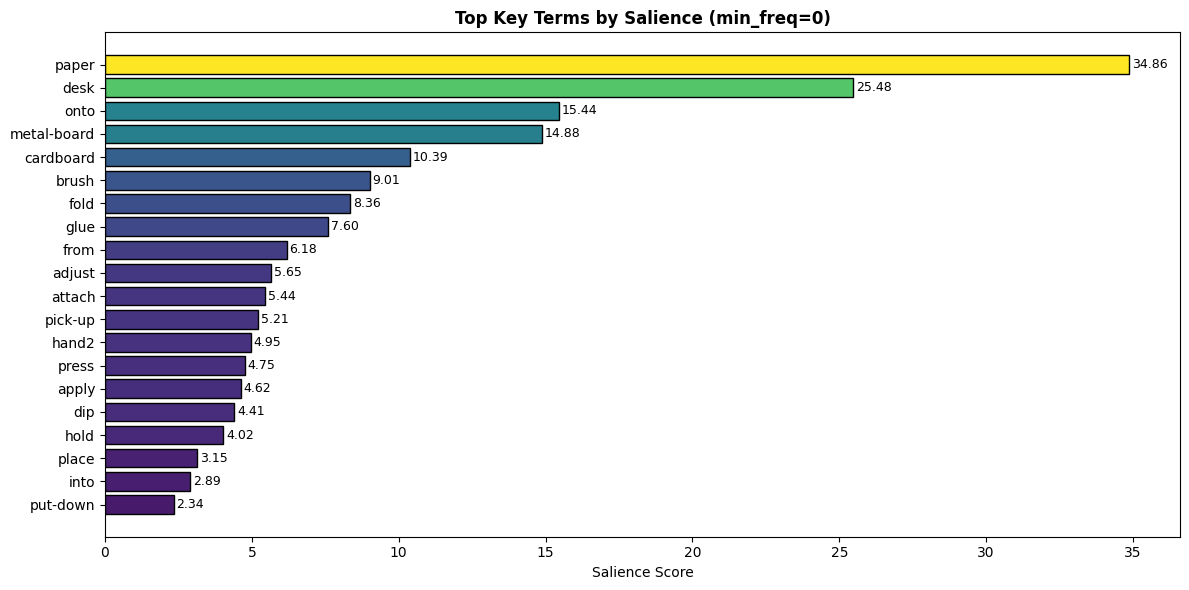

In [72]:
# Visualize key terms and their salience scores
if key_terms:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    terms = [t for t, _ in key_terms[:20]]  # Top 20
    scores = [s for _, s in key_terms[:20]]
    
    colors = plt.cm.viridis(np.array(scores) / max(scores))
    
    bars = ax.barh(range(len(terms)), scores, color=colors, edgecolor='black')
    ax.set_yticks(range(len(terms)))
    ax.set_yticklabels(terms)
    ax.set_xlabel('Salience Score')
    ax.set_title(f'Top Key Terms by Salience (min_freq={MIN_FREQ})', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    
    # Add score labels
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax.text(score + 0.1, i, f'{score:.2f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [73]:
# Summary table
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"\nCase: {case['data_id']}")
print(f"Question: {case['question']}")
print(f"Ground Truth: {case['ground_truth']}")
print(f"Error Category: {case['error_category']}")
print(f"\n--- Configuration ---")
print(f"threshold_std: {THRESHOLD_STD}")
print(f"min_freq: {MIN_FREQ}")
print(f"top_k: {TOP_K}")
print(f"use_llm: {USE_LLM}")
print(f"\n--- Episode Detection ---")
print(f"Number of actions: {len(action_sequence)}")
print(f"Number of key terms: {len(key_terms)}")
print(f"Number of episodes detected: {len(episode_boundaries)}")
for i, boundary in enumerate(episode_boundaries):
    verbs = [get_action_verb(action_sequence[idx]) for idx in boundary]
    print(f"  Episode {i}: {boundary} -> {verbs}")
print(f"\n--- QA Results (Model: {qa_model.__class__.__name__}) ---")
for prompt_type, result in results.items():
    status = 'CORRECT' if result['correct'] else 'WRONG'
    print(f"  {prompt_type:<15}: {result['prediction']:<20} [{status}]")


ANALYSIS SUMMARY

Case: 860980fb-f992-4bb1-8a46-b644f58090e2
Question: Which object required both hands for its first manipulation after being picked up?
Ground Truth: metal-board
Error Category: both_hands

--- Configuration ---
threshold_std: 0.5
min_freq: 0
top_k: None
use_llm: True

--- Episode Detection ---
Number of actions: 18
Number of key terms: 26
Number of episodes detected: 6
  Episode 0: [0, 1, 2] -> ['pick-up', 'place', 'adjust']
  Episode 1: [3, 4, 5, 6, 7, 8, 9, 10, 11] -> ['pick-up', 'fold', 'adjust', 'put-down', 'pick-up', 'hold', 'fold', 'place', 'pick-up']
  Episode 2: [12, 13] -> ['attach', 'press']
  Episode 3: [14, 15] -> ['pick-up', 'dip']
  Episode 4: [16] -> ['hold']
  Episode 5: [17] -> ['apply']

--- QA Results (Model: GPT5Mini) ---
  vanilla        : cardboard            [WRONG]
  hierarchical   : paper                [WRONG]
  cot            : paper, cardboard     [WRONG]


## 11. Experiment: Try Different Configurations

Quickly test different parameter combinations

In [74]:
def run_experiment(case, threshold_std, min_freq, top_k, model):
    """Run a complete experiment with given parameters."""
    # Initialize analyzer
    exp_analyzer = EpiMineActionAnalyzer(background_dataset=background, min_freq=min_freq)
    
    # Get key terms
    exp_key_terms = exp_analyzer.get_key_terms(case['context_graphs'], top_k=top_k)
    
    # Detect boundaries
    exp_boundaries = exp_analyzer.detect_episode_boundaries(case['context_graphs'], threshold_std=threshold_std)
    
    # Generate hierarchy (without LLM for speed)
    exp_generator = EpiMineEpisodeGenerator(model=GPT5Mini())
    exp_hierarchy = exp_generator.generate_episode_hierarchy(
        action_sequence=case['context_graphs'],
        episode_boundaries=exp_boundaries,
        key_terms=exp_key_terms,
        use_llm=False,  # Fast mode
    )
    
    # Generate prompts
    v_prompt = get_vanilla_prompt(case['context_graphs'], case['question'])
    h_prompt = get_hierarchical_prompt(exp_hierarchy, case['context_graphs'], case['question'])
    
    # Run QA
    v_pred, _ = run_single_qa(model, v_prompt)
    h_pred, _ = run_single_qa(model, h_prompt)
    
    return {
        'config': {'threshold_std': threshold_std, 'min_freq': min_freq, 'top_k': top_k},
        'num_episodes': len(exp_boundaries),
        'num_key_terms': len(exp_key_terms),
        'vanilla_pred': v_pred,
        'vanilla_correct': check_answer(v_pred, case['ground_truth']),
        'hierarchical_pred': h_pred,
        'hierarchical_correct': check_answer(h_pred, case['ground_truth']),
    }


print("Experiment function defined.")

Experiment function defined.


In [75]:
# Run experiments with different configurations
configs = [
    (1.0, 2, 10),  # threshold_std, min_freq, top_k
    (1.5, 2, 10),
    (2.0, 2, 10),
    (1.5, 1, 10),
    (1.5, 2, 5),
    (1.5, 2, None),  # all terms
]

print(f"Running {len(configs)} experiments on Case {CASE_INDEX}...")
print(f"Question: {case['question']}")
print(f"Ground Truth: {case['ground_truth']}")
print("\n" + "="*100)
print(f"{'Config':<30} {'#Ep':<5} {'#Terms':<8} {'Vanilla':<15} {'Hierarchical':<15}")
print("-"*100)

exp_results = []
for threshold_std, min_freq, top_k in configs:
    result = run_experiment(case, threshold_std, min_freq, top_k, qa_model)
    exp_results.append(result)
    
    config_str = f"t={threshold_std}, mf={min_freq}, k={top_k or 'all'}"
    v_status = 'CORRECT' if result['vanilla_correct'] else 'wrong'
    h_status = 'CORRECT' if result['hierarchical_correct'] else 'wrong'
    print(f"{config_str:<30} {result['num_episodes']:<5} {result['num_key_terms']:<8} {result['vanilla_pred']} ({v_status}){'':<5} {result['hierarchical_pred']} ({h_status})")

print("="*100)

Running 6 experiments on Case 0...
Question: Which object required both hands for its first manipulation after being picked up?
Ground Truth: metal-board

Config                         #Ep   #Terms   Vanilla         Hierarchical   
----------------------------------------------------------------------------------------------------
t=1.0, mf=2, k=10              3     10       paper (wrong)      paper (wrong)
t=1.5, mf=2, k=10              1     10       paper (wrong)      paper (wrong)
t=2.0, mf=2, k=10              1     10       paper (wrong)      paper (wrong)
t=1.5, mf=1, k=10              2     10       paper (wrong)      paper (wrong)
t=1.5, mf=2, k=5               1     5        cardboard (wrong)      paper (wrong)
t=1.5, mf=2, k=all             1     19       cardboard (wrong)      paper (wrong)
